In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

/Users/nathanlapierre/anaconda3/envs/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [5]:
# load ruggedness data from Statistical Rethinking book
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [6]:
# log transform response variable since it is highly skewed
# gdppc = GPP Per Capita
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [7]:
# convert np data array to a pytorch tensor
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

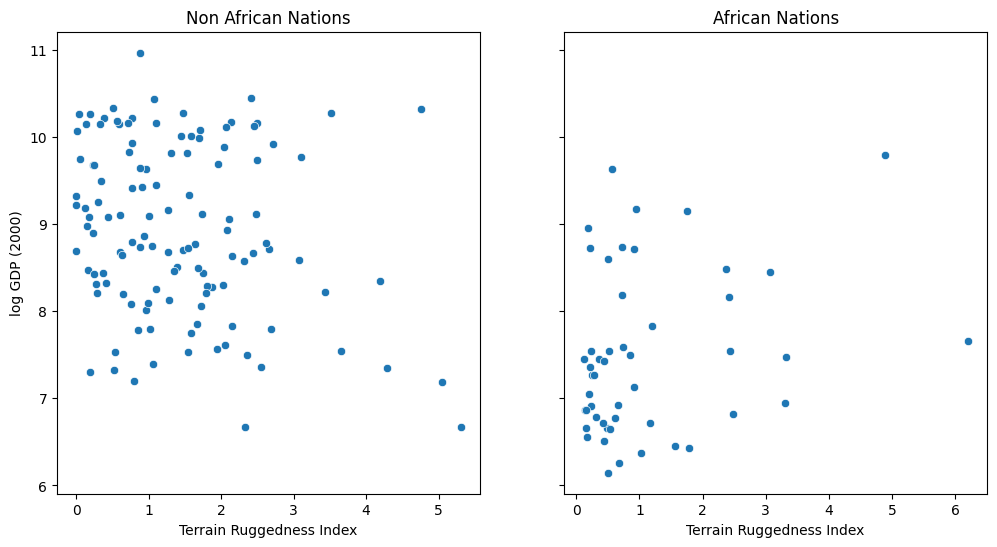

In [8]:
# visualize relationship between ruggedness and gdp
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

# Representation of a (Bayesian, in this case) linear regression model in pyro

```mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness```

We will be seeing whether ruggedness impacts GDP, both in and outside Africa, and whether ruggedness has different impacts on GDP depending on whether a country is in Africa

In [9]:
# define a Bayesian linear regression model in Pyro

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    # define paramaters of the model
    # most are initialized to be random noise
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    # we initialize sigma (variance) as a vector of ones, and constrain it to be non-negative using Pyro's constraints module
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    # specify the regression model
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    # defines an observed variable called "obs", whose observations are from log_gdp,
    #   and whose distirbution is normal centered around mean (specified above)
    #   with a variance of sigma
    # using pyro.plate allows the plate notation to be visualized; see below
    # also, it vectorizes sampling operations across all samples of ruggedness and log_gdp
    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

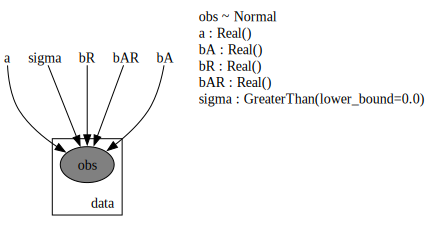

In [10]:
# visualize the plate notation of the model using pyro.render_model
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), 
                  render_distributions=True, render_params=True)


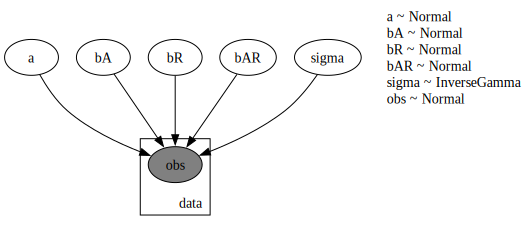

In [11]:
# now we define a more Bayesian model with normal priors on the parameters, except for sigma
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.InverseGamma(1, 1))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

# Defining the variational family

Pyro usually optimizes models using variational inference, though it supports other techniques as well. In Pyro, the variational distribution is called a "guide", and the user can either specify their own or use one of Pyro's prepackaged ones. We will specify a custom guide for our Bayesian linear regression below.

In [12]:
# custom guide (variational family)
# we will use a guide that models the distribution of unobserved parameters
#   in the model as a Gaussian with diagonal covariance, i.e. a mean-field approximation
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    # we'll define the "location" and "scale" (mean and variance) of each parameter in the model,
    #   often initializing the location as 0s. the scale must be non-negative
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.), constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(0.))
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    
    # now we sample the parameters from these
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.LogNormal(sigma_loc, torch.tensor(0.05)))  # fixed scale for simplicity
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}


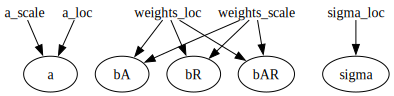

In [13]:
# use pyro.render_model to visualize custom_guide
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

In [14]:
# pyro also has a variety of "autoguides" that automatically generate some popular guides for us
# pyro's AutoNormal guide is exactly the same as the one we hand-wrote above
auto_guide = pyro.infer.autoguide.AutoNormal(model)

# Training / Optimization
Here we optimize the model using Stochastic Variational Inference (SVI).
Pyro has many different optimizers and many different ELBO estimators.
In this tutorial we use Trace_ELBO, which is always safe to use.

In [15]:
# use the Adam optimizer and the Trace ELBO, then set up the SVI optimizer
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

In [16]:
# now train the model for a bunch of steps and log the results
losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

Elbo loss: 6758.026973671047
Elbo loss: 740.237694144249
Elbo loss: 583.4062277078629
Elbo loss: 532.4112615585327
Elbo loss: 510.4218409061432
Elbo loss: 498.08109426498413
Elbo loss: 483.9628557562828
Elbo loss: 483.8791604042053
Elbo loss: 463.15965738892555
Elbo loss: 455.1979594230652


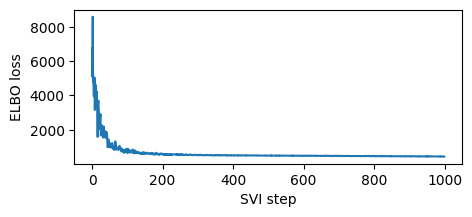

In [17]:
# print losses at each step
plt.figure(figsize=(5,2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [19]:
# display the final trained values of the guide parameter values
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

a 0.66135216
bA 0.2669241
bR 0.06167726
bAR 0.6213173
sigma 1.0
a_loc 0.0
a_scale 1.0
sigma_loc 0.0
weights_loc [0.66135216 0.2669241  0.06167726]
weights_scale [1. 1. 1.]
AutoNormal.locs.a 3.9731853
AutoNormal.scales.a 0.18919463
AutoNormal.locs.bA 1.7580143
AutoNormal.scales.bA 0.48272175
AutoNormal.locs.bR 2.0125046
AutoNormal.scales.bR 0.13025878
AutoNormal.locs.bAR -0.89087325
AutoNormal.scales.bAR 0.28228393
AutoNormal.locs.sigma 1.2201091
AutoNormal.scales.sigma 0.0777423


In [20]:
# we now revisit the question of how robust the relationship between terrain ruggedness and gdp
#   is against the uncertainty in the model parameter estimates
# to do so we plot the distribution of the slope of the log GDP given terrain ruggedness for
#   countries within and outside africa
# we represent these two distributions with samples drawn from our trained guide
# the pyro.plate statement vectorizes the 800 sample operations
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]  # we only have the interaction term if is_cont_africa=1

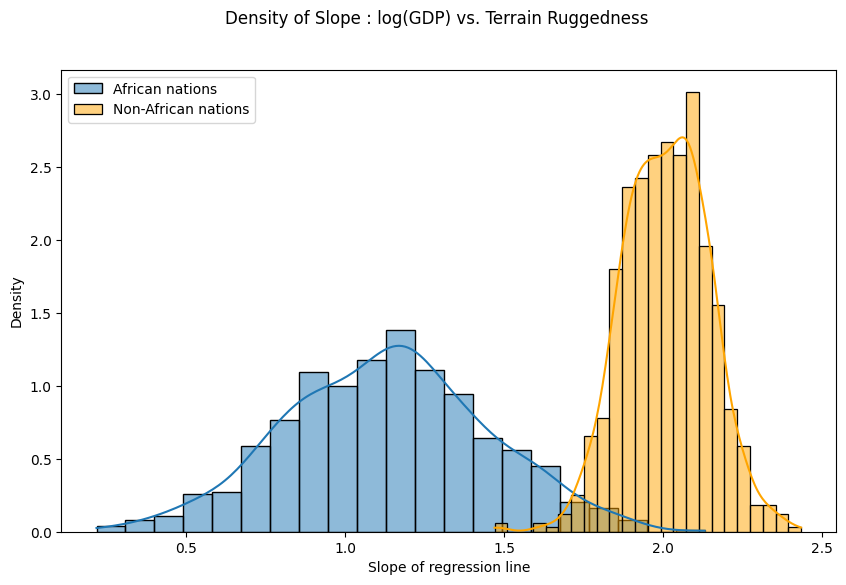

In [22]:
# plot the results
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()